In [11]:
# === Built-in ===
import os

# === Third-party ===
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import mahalanobis

# === PyTorch ===
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from collections import defaultdict

from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from PIL import Image

Classe per Estrazione delle Feature - Task 1-2

In [12]:
class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None
        self.model.avgpool.register_forward_hook(self._hook_avgpool)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def _hook_avgpool(self, module, input, output):
        self.feature = output.squeeze().detach().numpy()

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _ = self.model(input_tensor)

        feat_2048 = self.feature
        return 0.5 * (feat_2048[::2] + feat_2048[1::2])  # Ridotto a 1024

Estrazione,Salvataggio e Caricamneto delle Feature 

In [13]:
def process_and_save_features(base_folder, subfolders, output_file):
    extractor = ResNetAvgPool1024Extractor()
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extractor.extract_feature(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


def load_features(file_path):
    data = np.load(file_path, allow_pickle=True)
    return data["features"], data["filenames"], data["labels"]

Visualizzazione dei Risultati

In [14]:
def plot_matches(query_path, indices, labels, filenames, distances, metric_label):
    k = len(indices)
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))

    # Immagine query
    axs[0].imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    # Immagini simili
    for i, idx in enumerate(indices):
        img_path = os.path.join("Part1", labels[idx], filenames[idx])
        match_img = cv2.imread(img_path)
        axs[i + 1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i+1}\n{metric_label}={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

Ricerca Immagini Simili - Euclidea / Coseno  -- Task 3

In questa funzione chiamiamo una solo distanza 

In [15]:
def find_k_similar(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    dist_euc = euclidean_distances(features, query_feature).flatten()
    dist_cos = cosine_distances(features, query_feature).flatten()

    top_k_idx_euc = np.argsort(dist_euc)[:k]
    top_k_idx_cos = np.argsort(dist_cos)[:k]

    print(f"\nTop {k} simili a {img_path}:")
    print("=== Euclide ===")
    for rank, idx in enumerate(top_k_idx_euc):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Euclid: {dist_euc[idx]:.4f}")

    print("=== Coseno ===")
    for rank, idx in enumerate(top_k_idx_cos):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Cosine: {dist_cos[idx]:.4f}")

    # Visualizza entrambi
    plot_matches(img_path, top_k_idx_euc, labels, filenames, dist_euc, "Euclid")
    plot_matches(img_path, top_k_idx_cos, labels, filenames, dist_cos, "Cosine")

Ricerca Immagini Simili - Mahalanobis -- Task 3

In [16]:
def find_k_similar_mahalanobis(img_path, k, extractor, features, filenames, labels):
    query_feature = extractor.extract_feature(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)
    cov = np.cov(features.T)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Covarianza non invertibile. Uso pseudoinversa.")
        cov_inv = np.linalg.pinv(cov)

    distances = np.array([mahalanobis(query_feature, f, cov_inv) for f in features])
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} simili (Mahalanobis) a {img_path}:")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {distances[idx]:.2f}")

    plot_matches(img_path, top_k_idx, labels, filenames, distances, "M")

Esecuzione

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt1.npz
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet1024_pt2.npz
[FINE] Totale immagini processate: 3006

Top 5 simili a Part1/brain_glioma/brain_glioma_0005.jpg:
=== Euclide ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Euclid: 0.0000
2. brain_glioma_0071.jpg | Classe: brain_glioma | Euclid: 2.1480
3. brain_glioma_0258.jpg | Classe: brain_glioma | Euclid: 2.2868
4. brain_glioma_0311.jpg | Classe: brain_glioma | Euclid: 2.4746
5. brain_glioma_0717.jpg | Classe: brain_glioma | Euclid: 3.2342
=== Coseno ===
1. brain_glioma_0005.jpg | Classe: brain_glioma | Cosine: 0.0000
2. brain_glioma_0071.jpg | Classe: brain_glioma | Cosine: 0.0366
3. brain_glioma_0258.jpg | Classe: brain_glioma | Cosi

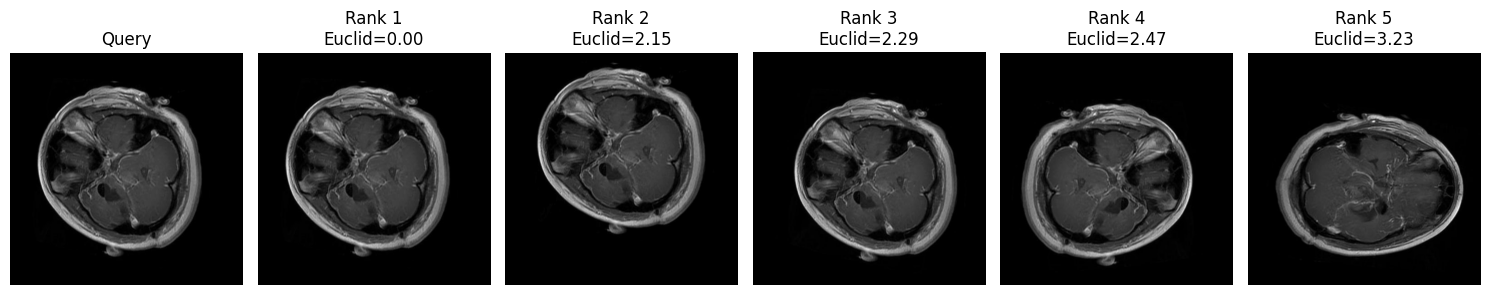

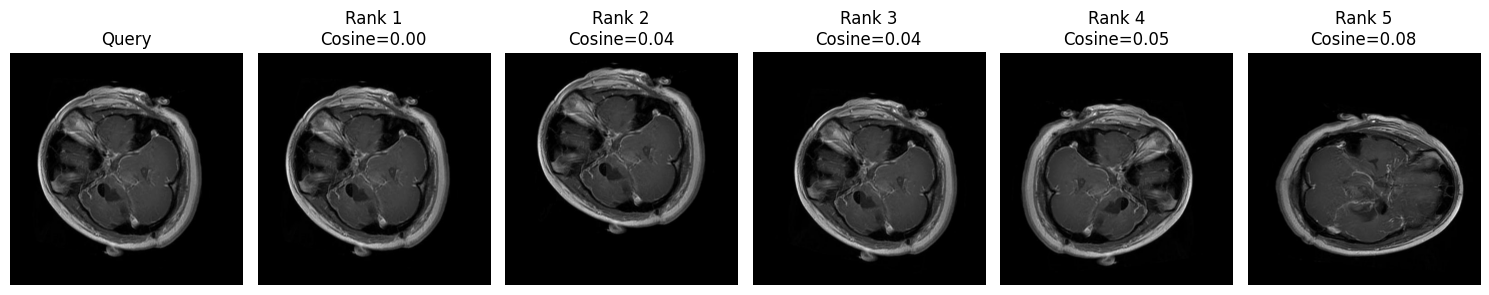


Top 5 simili (Mahalanobis) a Part1/brain_glioma/brain_glioma_0005.jpg:
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 30.94
3. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 31.58
4. brain_glioma_0311.jpg | Classe: brain_glioma | Distanza: 33.31
5. brain_menin_0578.jpg | Classe: brain_menin | Distanza: 34.19


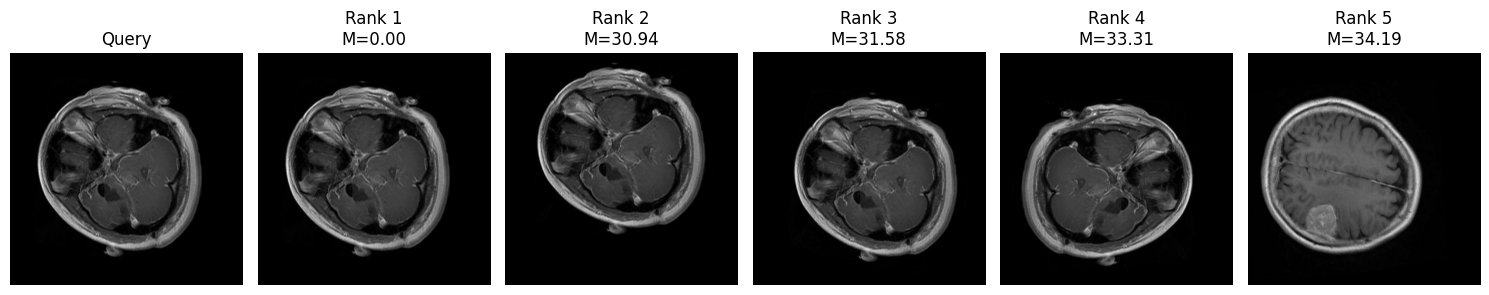

In [17]:
# === Parametri ===
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]



# === Estrai e salva features (solo una volta) ===
process_and_save_features("Part1", subfolders, "resnet1024_pt1.npz")
process_and_save_features("Part2", subfolders, "resnet1024_pt2.npz")

# === Carica features ===
features_pt1, filenames_pt1, labels_pt1 = load_features("resnet1024_pt1.npz")
features_pt2, filenames_pt2, labels_pt2 = load_features("resnet1024_pt2.npz")

# === Inizializza extractor ===
extractor = ResNetAvgPool1024Extractor()

# === Query ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)
find_k_similar_mahalanobis(query_img, k=5, extractor=extractor, features=features_pt1, filenames=filenames_pt1, labels=labels_pt1)

Task 4:

In [8]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def compute_metric(query_feat, target_feats, metric="euclidean"):
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return euclidean_distances(target_feats, query_feat).flatten()
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats).flatten()
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        dists_or_sims = compute_metric(query_feat, class_feats, metric)
        score = dists_or_sims.mean()
        scores.append(score)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

def predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    query_feat = extractor.extract_feature(query_img_path)
    if query_feat is None:
        print("[ERRORE] Feature non estratte.")
        return

    unique_labels = np.unique(labels)
    class_prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        class_prototypes.append(class_feats.mean(axis=0))
    class_prototypes = np.vstack(class_prototypes)

    scores = compute_metric(query_feat, class_prototypes, metric)

    if metric == "euclidean":
        top_k = np.argsort(scores)[:k]
    else:
        top_k = np.argsort(scores)[::-1][:k]

    print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
    for idx in top_k:
        print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

def task4_predict_labels_1024(query_img_path, k, extractor, features, labels, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")
    predict_top_k_labels_distance_mean_1024(query_img_path, k, extractor, features, labels, metric)
    predict_top_k_labels_prototype_1024(query_img_path, k, extractor, features, labels, metric)


In [ ]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="euclidean")
task4_predict_labels_1024(query_img, k=2, extractor=extractor, features=features_pt2, labels=labels_pt2, metric="cosine")

Task 5:

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

def task5_latent_semantics_resnet1024(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet AvgPool1024
    usando SVD, LDA o KMeans. Salva i risultati su file e visualizza lo spazio latente.
    """
    # === Carica feature ===
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data["features"]
    filenames = data["filenames"]
    labels = data["labels"]

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione 2D ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # === Salvataggio output ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa per KMeans

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

In [11]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [ ]:
# === ESEMPIO USO ===
task5_latent_semantics_resnet1024("resnet1024.npz", technique="svd", k=5)
task5_latent_semantics_resnet1024("resnet1024.npz", technique="lda", k=2)
task5_latent_semantics_resnet1024("resnet1024.npz", technique="kmeans", k=6)

Task 6:

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA su ResNet1024)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative


def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [ ]:
print("\nTask 6a – Dimensionalità intrinseca (globale):\n")
k_suggeriti_resnet1024 = suggest_k(features_pt1)
estimate_intrinsic_dimensionality(features_pt1, threshold=0.95, plot=True)


In [15]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}
    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(np.array(labels) == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" • Label '{label}' : k = {k}")
    return label_dim_map


In [ ]:
print("\nTask 6b – Dimensionalità intrinseca per etichetta (ResNet1024):\n")
label_dimensionalities_resnet1024 = estimate_dimensionality_per_label(
    features_pt1, labels_pt1, threshold=0.95
)


Task 7:

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import numpy as np

def compute_latent_semantics_per_class_resnet(X, y, k=10):
    class_models = {}
    class_means = {}
    labels = np.unique(y)

    for label in labels:
        X_class = X[np.array(y) == label]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)

        svd = TruncatedSVD(n_components=k, random_state=42)
        latent = svd.fit_transform(X_scaled)

        class_models[label] = {
            'scaler': scaler,
            'svd': svd,
            'latent_vectors': latent
        }
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_labels_with_latent_semantics(X_test, class_models, class_means):
    predictions = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))
            x_latent = model['svd'].transform(x_scaled)
            dist = np.linalg.norm(x_latent - class_means[label])
            if dist < min_dist:
                min_dist = dist
                best_label = label
        predictions.append(best_label)
    return predictions

def evaluate_predictions(y_true, y_pred):
    print("[VALUTAZIONE] Metriche per classe:")
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)
    for label, p, r, f in zip(np.unique(y_true), precision, recall, f1):
        print(f"Classe {label}: Precisione={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")
    print(f"\nAccuratezza globale: {accuracy:.2f}\n")
    print(classification_report(y_true, y_pred))

In [ ]:
# ====== ESECUZIONE ======

# Step 1: addestramento sulle immagini Part1
class_models_resnet1024, class_means_resnet1024 = compute_latent_semantics_per_class_resnet(
    features_pt1, labels_pt1, k=10
)

# Step 2: predizione sulle immagini Part2
predicted_labels_resnet1024 = predict_labels_with_latent_semantics(
    features_pt2, class_models_resnet1024, class_means_resnet1024
)

# Step 3: valutazione delle predizioni
evaluate_predictions(labels_pt2, predicted_labels_resnet1024)

Task 8

In [21]:
def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni con PCA, quindi applica DBSCAN
    e restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA -> Riduzione a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più popolosi" che vogliamo restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1) 
    ordinati in base alla dimensione (numero di occorrenze) decrescente.
    Se DBSCAN ha trovato meno di c cluster, restituisce tutti quelli disponibili.
    """
    # Conteggio delle occorrenze per ogni etichetta di cluster
    label_counts = Counter(cluster_labels)
    # Rimuovo il rumore (-1) se presente
    label_counts.pop(-1, None)
    
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i c cluster più frequenti
    most_common = label_counts.most_common(c)  # es. [(label1, count1), (label2, count2), ...]
    top = [int(lbl) for lbl, _ in most_common]
    
    # Se DBSCAN ha trovato meno di c cluster, most_common contiene già tutti
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle tue feature originali (senza aver fatto PCA).
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi pari ai cluster "significativi" (col più grandi).
    metric: la distanza da usare per MDS (default 'euclidean').
    Mostra un grafico 2D (scatter) con i punti appartenenti ai top_clusters colorati diversamente,
    tutti gli altri (cluster minori o -1) in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le features originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Calcolo la matrice di distanze (facoltativo) e poi MDS → Y (N×2)
    #    Qui usiamo MDS “direttamente” su features_scaled, che di default assume euclidea.
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    Y = mds.fit_transform(features_scaled)

    # 3) Plotto i punti
    import matplotlib
    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16‐25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)


            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()


In [ ]:
# ================================
# BLOCCHETTO PER TASK 8 (RIUSO FUNZIONI)
# ================================

# 3) PARAMETRI (modificabili a piacere)
eps = 2.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label

# 4) Creare una cartella di output (facoltativo)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 3) Costruisco l’elenco dei full path per tutte le immagini
base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
images_full = [ os.path.join(base_folder, lbl, fname)
                for fname, lbl in zip(filenames_pt1, labels_pt1) ]

# 5) SCORRO OGNI LABEL DI Parte1 E APPLICO DBSCAN+PCA
unique_labels = np.unique(labels_pt1)  # es. ["Glioma","Meningioma","Pituitary"]

for lbl in unique_labels:
    print(f"\n==============================")
    print(f"[INFO] Elaboro label: {lbl}")
    print(f"==============================")

    # 5.1) Estraggo le righe di feat_matrix_part1 / flname_part1 corrispondenti
    mask_lbl = (labels_pt1 == lbl)
    features_label = features_pt1[mask_lbl]   # shape = (n_i, d)
    images_label   = np.array(images_full)[mask_lbl]

    # 5.2) Chiamo la tua funzione che fa PCA + DBSCAN
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

    # 5.3) Trovo i c cluster più grandi
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 5.4) Creo sotto-cartella di output per questa label
    out_dir_lbl = os.path.join(output_base, f"label_{lbl}")
    os.makedirs(out_dir_lbl, exist_ok=True)

    # 5.5) MDS‐2D + scatter plot del clustering
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    # (ATTENZIONE: plot_mds_clusters in genere “fa plt.show()” a video.
    #  Se vuoi salvare l’immagine invece di far vedere a notebook, 
    #  devi modificare leggermente quella funzione per usare plt.savefig())
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se invece vuoi **salvare** l’immagine in PNG anziché fare “show()”:
    #    plt.savefig(os.path.join(out_dir_lbl, f"{lbl}_MDS_clusters.png"))
    #    plt.close()

    # 5.6) Creo le miniature di ogni cluster “significativo”
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,      # array di stringhe di percorsi
        cluster_labels,    # array di int di lunghezza n_i
        top_clusters,      # la lista dei c indici di cluster
        thumb_size=(64, 64)
    )
    # Anche qui, di default quella funzione fa plt.show() per ogni cluster.
    # Se vuoi salvare le figure in file, modifica show_cluster_thumbnails in
    # modo che setti un outpath e faccia plt.savefig().

print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


task 9

In [ ]:


# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(features_pt1, labels_pt1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(features_pt1, labels_pt1)

# Predizioni su Part2
pred_knn = knn_model.predict(features_pt2)
pred_dt = dt_model.predict(features_pt2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(labels_pt2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(labels_pt2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(labels_pt2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(labels_pt2, pred_dt))


Task 10

In [18]:
class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea con quantizzazione (p-stable).
    num_layers = L, num_hashes = h, dim = D, r = bucket width.
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        bits = []
        for j in range(self.h):
            a_j = self.a_vectors[layer_idx][j]
            b_j = self.b_offsets[layer_idx][j]
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            bits.append(h_val)
        return tuple(bits)

    def index(self, vectors: np.ndarray):
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Dimensione vettore ({D}) ≠ D di LSH ({self.d})."
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        assert q_vec.shape[0] == self.d, "Dimensione query ≠ D."
        candidati = set()
        total_checked = 0
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked



In [ ]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(features_pt1, axis=0)
feat_centered = features_pt1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 5                      # numero di funzioni concatenati in ciascuna tavola
r = 1                      # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


In [22]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    print(img_path)
    raw_q = np.array(ResNetAvgPool1024Extractor.extract_feature(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = labels_pt1[idx]
        fname = filenames_pt1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = labels_pt1[idx]
        fname = filenames_pt1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [23]:
# Utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_menin/brain_menin_1003.jpg"

print(query_path);
k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)



Part2/brain_menin/brain_menin_1003.jpg


TypeError: ResNetAvgPool1024Extractor.extract_feature() missing 1 required positional argument: 'image_path'